In [1]:
from __future__ import print_function
import time
import intrinio_sdk
from intrinio_sdk.rest import ApiException
from pprint import pprint
import matplotlib.pyplot as plt
intrinio_sdk.ApiClient().configuration.api_key['api_key'] = 'OmNjN2M0YzRjMjNhZjQ1Zjc3NzZiODI4MmNjMjc4Njgw'

In [2]:
import math
#import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


In [3]:
security_api = intrinio_sdk.SecurityApi()

identifier = 'MSFT' # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
start_date = '2010-01-01' # date | Return prices on or after the date (optional)
end_date = '2020-07-27' # date | Return prices on or before the date (optional)
frequency = 'daily' # str | Return stock prices in the given frequency (optional) (default to daily)
page_size = 3000 # int | The number of results to return (optional) (default to 100)
next_page = '' # str | Gets the next page of data from a previous API call (optional)

try:
  api_response = security_api.get_security_stock_prices(identifier, start_date=start_date, end_date=end_date, frequency=frequency, page_size=page_size, next_page=next_page)
  #pprint(api_response)
except ApiException as e:
  print("Exception when calling SecurityApi->get_security_stock_prices: %s\r\n" % e)
        

In [4]:
t=[]
print(len(api_response.stock_prices))
for i in range(len(api_response.stock_prices)):
    temp = api_response.stock_prices[i].open
    t.append(temp)

2667


In [5]:
df = pd.DataFrame(api_response.stock_prices_dict)


In [6]:
df.sort_values(["date"], axis=0, 
                 ascending=True, inplace=True) 

In [7]:
df.set_index('date',inplace=True)

In [8]:
df.head()


,intraperiod,frequency,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,
2010-01-04,False,daily,30.65,31.10,30.59,30.950,38414185.0,23.992776,24.345035,23.945808,24.227615,38414185.0
2010-01-05,False,daily,30.87,31.10,30.64,30.960,49758862.0,24.164991,24.345035,23.984948,24.235443,49758862.0
2010-01-06,False,daily,30.88,31.08,30.52,30.770,58182332.0,24.172819,24.329379,23.891012,24.086711,58182332.0
2010-01-07,False,daily,30.61,30.70,30.19,30.452,50564285.0,23.961464,24.031916,23.632688,23.837782,50564285.0
2010-01-08,False,daily,30.27,30.88,30.24,30.660,51201289.0,23.695312,24.172819,23.671828,24.000604,51201289.0


In [9]:
df.shape

(2667, 12)

In [10]:
#df['close'].plot(figsize=(16,6))

C:\Users\Akhilesh\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


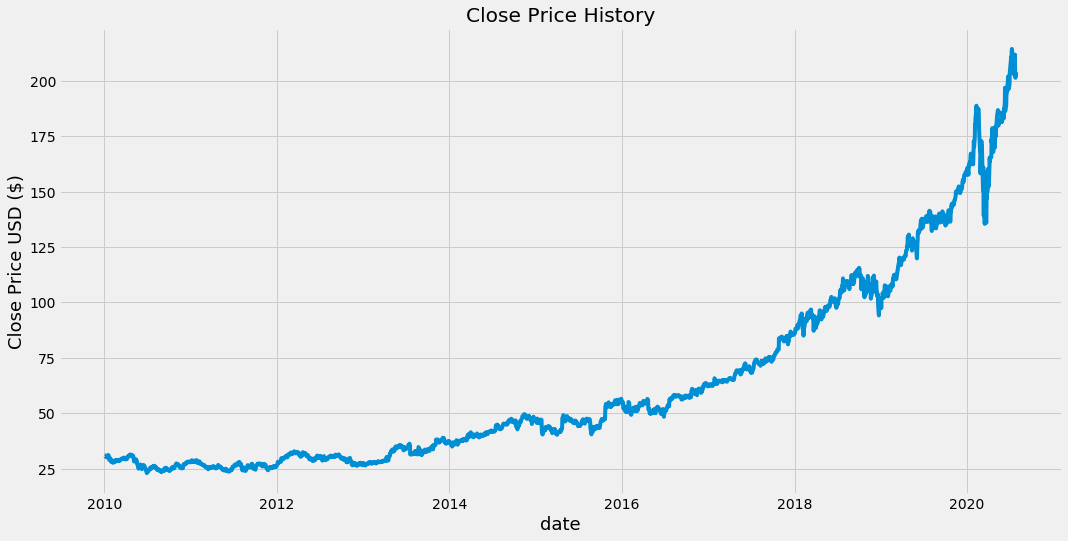

In [11]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])

plt.xlabel('date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [12]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 

In [13]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [14]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

In [15]:
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [16]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [17]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
#Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [19]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)


Epoch 1/1
2074/2074 [==============================] - 116s 56ms/step - loss: 2.2199e-04


In [20]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [21]:
#Convert x_test to a numpy array 
x_test = np.array(x_test)

In [22]:
#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [23]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [24]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

8.189745485438833

C:\Users\Akhilesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


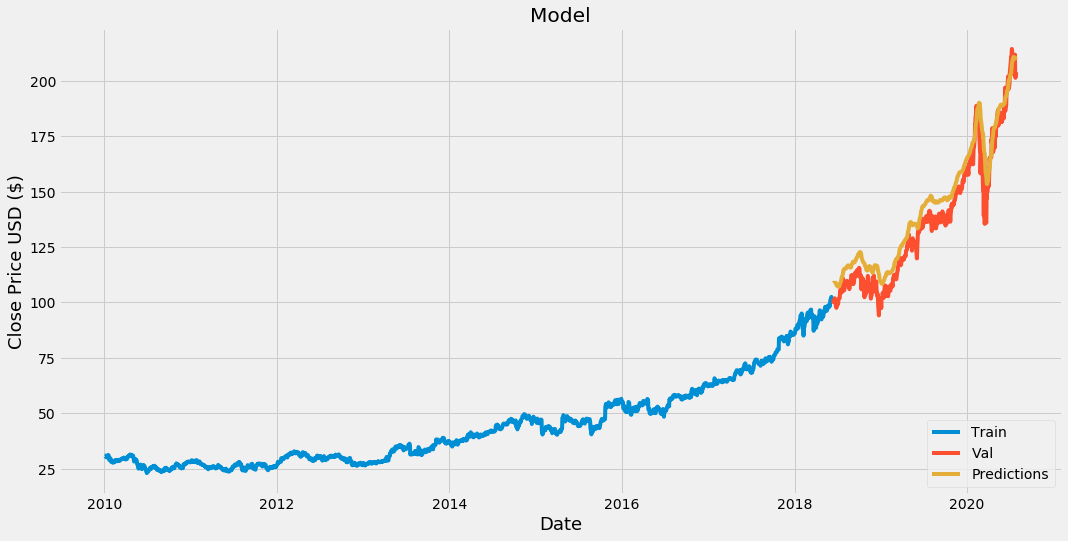

In [25]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [26]:
#Show the valid and predicted prices
valid

,close,Predictions
date,,
2018-06-14,101.42,108.739357
2018-06-15,100.13,108.829926
2018-06-18,100.86,108.801407
2018-06-19,100.86,108.775505
2018-06-20,101.87,108.751144
...,...,...
2020-07-21,208.75,210.001877
2020-07-22,211.75,210.076797
2020-07-23,202.54,210.391312


In [27]:
security_api = intrinio_sdk.SecurityApi()

identifier = 'MSFT' # str | A Security identifier (Ticker, FIGI, ISIN, CUSIP, Intrinio ID)
start_date = '2020-07-' # date | Return prices on or after the date (optional)
end_date = '2020-07-27' # date | Return prices on or before the date (optional)
frequency = 'daily' # str | Return stock prices in the given frequency (optional) (default to daily)
page_size = 3000 # int | The number of results to return (optional) (default to 100)
next_page = '' # str | Gets the next page of data from a previous API call (optional)

try:
  api_response = security_api.get_security_stock_prices(identifier, start_date=start_date, end_date=end_date, frequency=frequency, page_size=page_size, next_page=next_page)
  #pprint(api_response)
except ApiException as e:
  print("Exception when calling SecurityApi->get_security_stock_prices: %s\r\n" % e)

In [28]:
df1 = pd.DataFrame(api_response.stock_prices_dict)

In [29]:
df1.sort_values(["date"], axis=0, 
                 ascending=True, inplace=True) 

In [30]:
df1.set_index('date',inplace=True)

In [31]:
df1.head()

,intraperiod,frequency,open,high,low,close,volume,adj_open,adj_high,adj_low,adj_close,adj_volume
date,,,,,,,,,,,,
2008-09-10,False,daily,26.55,26.86,26.25,26.44,75064901.0,20.170415,20.405926,19.942500,20.086846,75064901.0
2008-09-11,False,daily,26.09,27.46,26.03,27.34,72914650.0,19.820946,20.861755,19.775363,20.770589,72914650.0
2008-09-12,False,daily,27.20,27.74,26.94,27.62,75628494.0,20.664229,21.074475,20.466703,20.983309,75628494.0
2008-09-15,False,daily,26.93,27.49,26.73,26.82,82349376.0,20.459106,20.884546,20.307163,20.375537,82349376.0
2008-09-16,False,daily,26.10,26.49,25.52,25.99,111729652.0,19.828543,20.124832,19.387909,19.744975,111729652.0


In [32]:
#Create a new dataframe
new_df = df1.filter(['close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-60:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[209.04617]]
